In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from datetime import datetime as dt
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path

csv_path = Path.cwd() / 'data' / 'bitstamp_hourly.csv'
df = pd.read_csv(csv_path)
df['timestamp'] = df['timestamp'].apply(lambda x: dt.fromtimestamp(x))

# Studying Bitcoin's Historical Volatility

## Introduction

Bitcoin's volatility is a source of continuous debates because a high volatility impairs its use as medium of exchange and unit of account in economic exchanges: it therefore prevents Bitcoin to be adopted as money. 

During Bitcoin's early days, Bitcoin's supporters advanced the hypothesis that its future volatility would be inversely correlated to the size of its market capitalization, i.e the outstanding value of all Bitcoins. 

In early 2021, Bitcoin's market capitalization reached 1 trillion dollars, putting it on pars with major fiat currencies such as the Swiss franc and a considerable fraction of the investable gold market. But is Bitcoin's volatility lower today than when its marketcap was hundreds of time smaller? This is the focus on this investigation.

## Defining Volatility

A tradable asset can be described by a discrete time series of prices $S_{n}$. This time series is a sample, taken with a constant sampling frequency that can be daily, hourly or even at the minute level, of the entire tick-by-tick, trade-by-trade price history of the asset, that we can consider continous. That price history is the population from our sample: the goal of our statistical analysis is to infer population properties from data from the sample, which we will demonstrate.

Volatility is generally defined as a measure of dispersion of the price returns in the time series. Since we are analyzing data from a sample taken from the population, we can only estimate volatility using statistical estimators. Ideally, we want a statistical estimator that is unbiased and efficient. 

In statistics, bias is defined as the difference between an estimator's expected value and the true value of the parameter being estimated. 

We also want an estimator that is stable from sample to sample: the less prone to sampling error an estimator is, the more efficient it is.

**Volatility as Stastistical Estimator** The square root of the variance of the price returns in the sample, which also defines the standard deviation of a normal distribution, is the most commonly used statistical estimator for volatility.Volatility is usually reported as an annualized metric, so that the resulting variance has to be multiplied by the number of trading periods in one year.  

Let's assume that we sample a time series of N consecutive prices $S_{n}$ of our security. Then the sample variance is defined as 

\begin{align*}
s^2 = \frac{1}{N} \sum_{i=1}^N \left(x_i - \bar x \right)^2
\end{align*}

where $ x_i = \ln\left(\frac{S_i}{S_{i-1}}\right) $  and $\bar x = \frac{1}{N} \sum_{i=1}^N x_i $ is the mean log returns in the sample, also called drift. As the drift, which is a log return, may greatly depend on the sample considered and it is should be small in the period considered, by setting $\bar x = 0$ we reduce a source of potential noise in our volatility estimate {cite}`option_trading`.

**From Sample to Population Estimate** Since we are actually interested in the population variance, we must know how to infer it from the sample variance {cite}`fundamentals_quant_finance`. The sample variance defined above is a well known *biased estimator* of the population variance $\sigma^2$, so that it needs to be multiplied by a factor $n/(n-1)$ to remove the bias {cite}`option_trading` (this is called Bernoulli's correction):

\begin{align*}

\sigma^2 = \frac{N}{N - 1} s^2

\end{align*}

We can already see that the sample size N is quite important, but it becomes even more important if we consider the variance of the sample variance itself:

\begin{align*}

var(s) \approx \frac{\sigma^2}{2N} 

\end{align*}

In fact, for small $N$ such as the commonly used $N=20$ or $N=30$, the uncertainity on the sample variance can be quite high. Much better to use N of 60 and above {cite}`option_trading`.

So why shouldn't we always use a high N in our volatility estimate? Firstly, a high N could make jumps or trading discountinity persist in our estimate, leading to an overestimate. Secondly, since we often use daily closes as pricing data, looking up to 60 days in the past may provide us with information on volatility which is not anymore current. 



**Bitcoin Data** Although Bitcoin is traded 24/7 globally, it does often present large price movements. Moreover, volatility regimes shift in Bitcoin happens very quickly: 60 daily closes would be a far too long time period to have an up-to-date volatility estimate. If we want to be accurate in our estimate of volatility and at the same time avoid the impact of the jumps on the data, we can use a high N but use more granular data, such as hourly data, instead of daily closes. We must take that into consideration when we annualize the volatility by multiplying with the correct factor.


## Analysis
In the first chart, I plotted Bitcoin's close on close annualized hourly volatility with a period of 60 hours. 


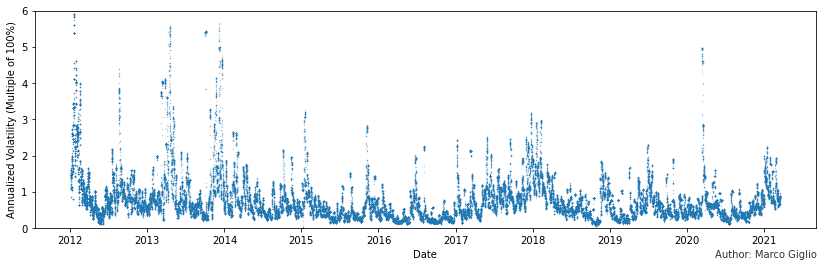

In [2]:
def estimate_realized_volatility(closes):
    sample_variance = 0

    for i in range(0, len(closes) - 1):
        daily_log_return = np.log((float(closes[i + 1])/ float(closes[i])))
        sample_variance += np.power(daily_log_return, 2)

    pop_variance = (sample_variance) / (60 - 1)
    return np.sqrt(365*24) * np.sqrt(pop_variance)

volatilities = df['close'].rolling(window=60).apply(estimate_realized_volatility, raw=True, engine='numba')
df = df.assign(volatilities=volatilities.values)

cmap = cm.get_cmap('cool')
ax = df.plot.scatter(x='timestamp', y='volatilities', s=0.1, cmap=cmap, alpha=0.5)
fig = ax.get_figure()
fig.set_size_inches(14, 4)
fig.text(0.8, 0.05, 'Author: Marco Giglio',
         fontsize=10, color='black',
         ha='left', va='top', alpha=0.8)
plt.xlabel('Date')
plt.ylim(0, 6)
plt.ylabel('Annualized Volatility (Multiple of 100%)')
plt.savefig('vol_time.png', dpi=300)


Already from this very high view graph, we can see a few things:

* Bitcoin's volatility presents many extreme spikes, which have become considerably more rare in recent years.
* Bitcoin's typical volatility remains substantial and it shows an upward trending pattern during bull markets and downward during bear markets. From this high view, it doesn't appear to have diminished significantly, if not at all.
* The March 2020 crash was an outlier comparable to 2014's events.

### Comparing the Histograms of Volatilities at Different Times
How can we extract more information from the data? Since we have pricing data with a decent resolution, we can build histograms of the volatilites, by taking slices of our sample, and see how they have changed: i.e we want to compare volatility regimes at different periods in the history of Bitcoin.

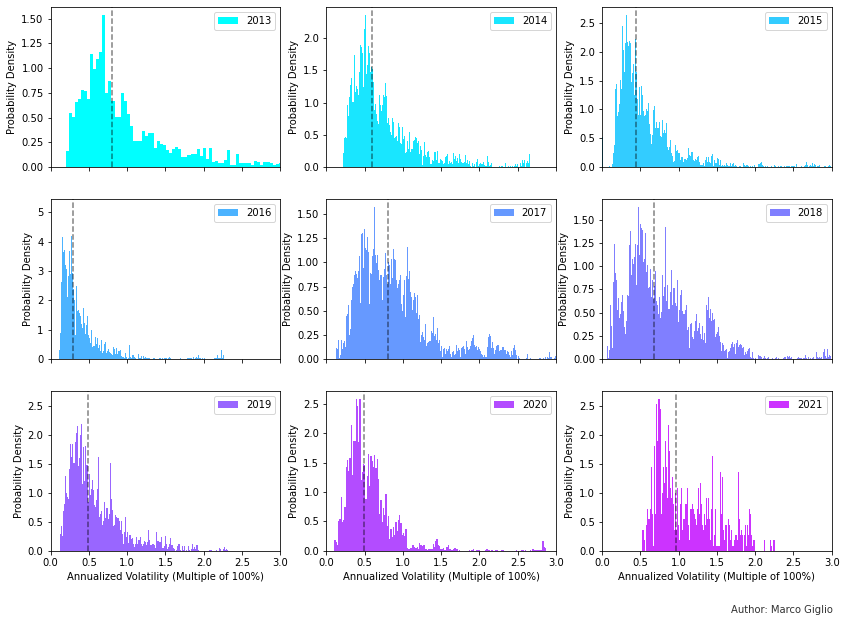

In [3]:

fig, axes = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(14, 10)

for i in range(0,9):
    j,k = np.unravel_index(i, shape=(3,3), order='C')
    start = df['timestamp'] > dt.strptime(str(2013 + i) + '-01-01','%Y-%m-%d')
    end = df['timestamp'] < dt.strptime(str(2014 + i) + '-01-01','%Y-%m-%d')
    
    ax = df[start & end]['volatilities'].plot.hist(ax=axes[j,k], bins=300, color=cmap(float(i)/10), label=str(2013 + i), density=True, sharex=True)
    median = df[start & end]['volatilities'].median()
    ax.axline((median, 0), (median, 1), linestyle='--', color='black', alpha=0.5)
    axes[j, k].legend()


for i,ax in enumerate(axes.flat):
    ax.set(xlabel='Annualized Volatility (Multiple of 100%)', ylabel='Probability Density')
    ax.set(xlim=(0,3))
   
    
fig.text(0.8, 0.05, 'Author: Marco Giglio',
         fontsize=10, color='black',
         ha='left', va='top', alpha=0.8)
plt.savefig('hist_subplot.png', dpi=300)



The histograms show the distribution of volatilities in each year between 2013 and 2021, though the data for the current solar year is clearly incomplete. The dashed line in each subplot is the median volatility for that year. We can notice a few things:

* The distribution of volatilities roughly approximates positive skewed, leptokurtic (i.e fat-tailed) normal distributions due to volatility clustering and the presence of price jumps {cite}`fundamentals_quant_finance`

* We can see how the median volatility evolves over time, increasing in bull markets and decreasing in bear markets.

* 2016 had very low volatility, much lower than any later years.

* Bitcoin's median volatility has a range between 50% and 100% annualized volatility, but it doesn't appear to be trending down significantly over time, especially in recent years. 

Could it be that our conclusions are due to the way we sliced the data, from the beginning to the end of each solar year? 

### Mean and Median Over Time using Rolling Windows 

Alternatively, we can plot the median and mean over time of a rolling window of our sample. We can also compare different window sizes to see how the size of the slice can affect our data. 



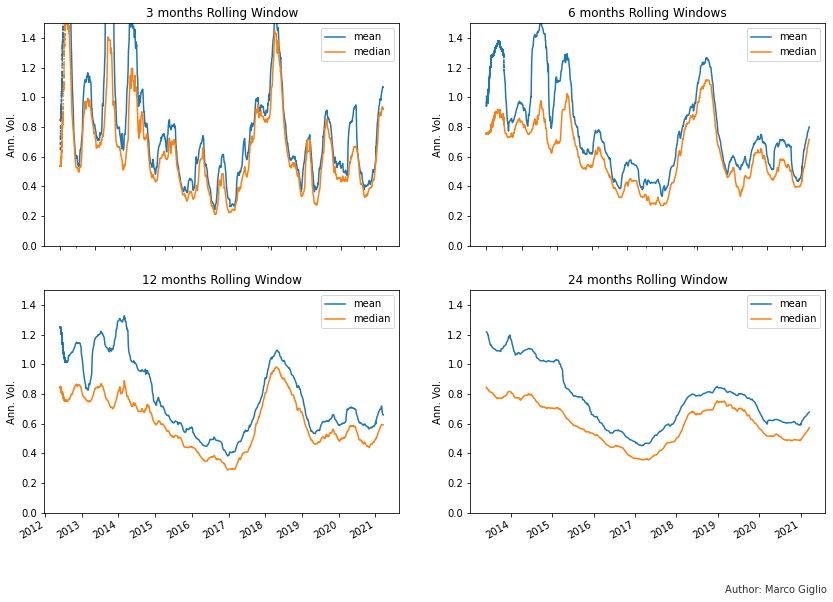

In [4]:
# Compute the mean and the std of the data over a rolling 3, 6, 12, 24-months windows 
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(14, 10)
window_sizes = [3*30*24, 6*30*24, 12*30*24, 24*30*24]
for i, window_size in enumerate(window_sizes):
    mean = df['volatilities'].rolling(window=window_size).mean()
    median = df['volatilities'].rolling(window=window_size).median()
    std = df['volatilities'].rolling(window=window_size).std()
    df = df.assign(mean=mean.values)
    df = df.assign(median=median.values)
    df = df.assign(std=std.values)
    j = 1 if i > 1 else 0
    df.plot(ax=axes[j, i%2], x='timestamp', y=['mean','median'],ylabel='Ann. Vol.', sharex=True)
                
for i, ax in enumerate(axes.flat):
    ax.set(ylim=(0,1.5))
    ax.set(xlabel=None)
    

axes[0,0].set_title("3 months Rolling Window")
axes[0,1].set_title("6 months Rolling Windows")    
axes[1,0].set_title("12 months Rolling Window")    
axes[1,1].set_title("24 months Rolling Window")    


fig.text(0.8, 0.1, 'Author: Marco Giglio',
         fontsize=10, color='black',
         ha='left', va='top', alpha=0.8)
plt.savefig('rolling_subplot.png', dpi=300)


The evolution of the median and mean volatility over time clearly shows that:

* Volatility begins to rise in bull markets, but it skyrockets in the first year after a bull market ends: the years 2014 and 2018 show extremely high volatility.
* It takes a few years for volatility to stabilize after a bull market
* The year of 2016 was an outlier, with a very reduced volatility, lower than any following period in Bitcoin's history. But not just its median volatility was lower, but as you can see in the following chart, every quantiles of the empirical distribution was lower. 

The following quantiles chart highlights even more how Bitcoin's most volatile days are as volatile as in 2015, when Bitcoin's market capitalization was 200-300 times lower.

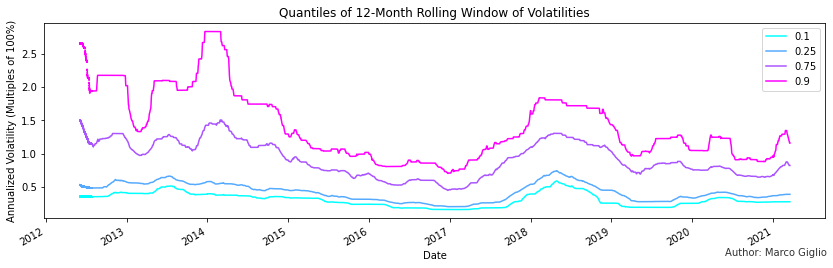

In [5]:
cmap = cm.get_cmap('cool')

window_size = 12*30*24
quantiles = [.1, .25, .75, .90]

for quantile in quantiles: 
    data = df['volatilities'].rolling(window=window_size).quantile(quantile)
    serie = pd.Series(data, name=str(quantile))
    df[serie.name] = serie
    
ax = df.plot(x='timestamp', y=['0.1', '0.25', '0.75', '0.9'], cmap=cmap, legend=False, ylabel='Annualized Volatility (Multiples of 100%)', xlabel='Date', title='Quantiles of 12-Month Rolling Window of Volatilities')

fig = ax.get_figure()
fig.set_size_inches(14, 4)

ax.legend()
fig.text(0.8, 0.1, 'Author: Marco Giglio',
         fontsize=10, color='black',
         ha='left', va='top', alpha=0.8)

plt.savefig('quantiles.png', dpi=300)


## Conclusion

Bitcoin's volatility shows a pattern of increasing during bull markets and early bear market cycles, to then slowly fall and stabilize. Bitcoin's volatility today shows less extreme events than in the early days of 2012-2014, but its median volatility is not much lower. Remarkably, Bitcoin has been considerably more volatile than the year 2016 in recent years, and the current 90% quantile of the last 12 months show Bitcoin being more volatile than the year 2015, when Bitcoin's marketcap was 300 times lower than today. 

## Future Research Direction

* **Alternative estimators**: the close-on-close volatility estimator can not handle jumps in returns well, as they increase volatility for the entire window/period before dropping out. Alternative models exist, such as the Exponentially Weighted Moving Average (EWMA) and the family of GARCH models. 

* **High Frequency Data**: today we can collect and process high-frequency pricing data easily and, in theory, we could collect and analyze tick-by-tick data. On timescales so short, market microstructure, such as the bid-ask spread and exchange liquidity, will have a large effect on the volatility estimate, but there are tools and instruments that we can use to analyze and decouple those effects. 

* **Volatility of Volatility**: How does volatility itself change over time and how it has been changing in the last decade?

* **Impacts of Derivatives**: 2016 was the last year spot Bitcoin volumes where comparable in size with derivatives volumes. In May 2016, BitMex launched the first BTCUSD perpetual swap, an innovation that had a large impact in the crypto industry, and it was copied by many other centralized and decentralized exchanges. Derivatives enable market participants to use extreme leverage, which can increase the size of price moves, especially when the price falls and overleverage traders are liquidated. Can derivatives have a measureable impact on Bitcoin volatility then? This is something worth looking into. 

## Bibliography 

```{bibliography}

```